### Import libraries

In [1]:
import os
import requests
from datetime import datetime, timedelta
from glob import glob
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### load and combine csvs
### then save to csv

In [2]:
#csv_files = glob("./MISO_quarterly_data/*DA*.csv")  

In [3]:
"""import re
from io import StringIO

def clean_file(path):
    with open(path, "r") as fh:
        txt = fh.read()
    # remove commas *inside* numbers (e.g. 1,234.56 → 1234.56)
    return re.sub(r'(?<=\d),(?=\d{3}(?:\.\d+)?\b)', '', txt)

dfs = {}
for f in csv_files:
    clean_txt = clean_file(f)
    temp_df = pd.read_csv(StringIO(clean_txt), low_memory=False)
    dfs[f] = temp_df[temp_df['NODE'] == 'NSP.NWELOAD']
"""

'import re\nfrom io import StringIO\n\ndef clean_file(path):\n    with open(path, "r") as fh:\n        txt = fh.read()\n    # remove commas *inside* numbers (e.g. 1,234.56 → 1234.56)\n    return re.sub(r\'(?<=\\d),(?=\\d{3}(?:\\.\\d+)?\x08)\', \'\', txt)\n\ndfs = {}\nfor f in csv_files:\n    clean_txt = clean_file(f)\n    temp_df = pd.read_csv(StringIO(clean_txt), low_memory=False)\n    dfs[f] = temp_df[temp_df[\'NODE\'] == \'NSP.NWELOAD\']\n'

In [4]:
#combined_df = pd.concat(dfs, ignore_index=True)

In [5]:
#combined_df.to_csv("./data_gold/Node_DA.csv")

## explore RT node data

In [2]:
node_RT = pd.read_csv("../data/Node_RT.csv")
node_DA = pd.read_csv("../data/Node_DA_LMP.csv")

In [3]:
node_RT_LMP = node_RT[node_RT['VALUE'] == 'LMP']
node_RT_LMP = node_RT_LMP.drop(columns=node_RT_LMP.columns[0])#.set_index('MARKET_DAY')
node_RT_LMP['date'] = pd.to_datetime(node_RT_LMP['MARKET_DAY']) 
node_RT_LMP['Month'] = node_RT_LMP['date'].dt.month
node_DA_LMP = node_DA
node_DA_LMP['date'] = pd.to_datetime(node_DA_LMP['MARKET_DAY'])
node_DA_LMP['Month'] = node_DA_LMP['date'].dt.month
node_DA_LMP.drop(columns=["source_zip"], inplace=True)

In [4]:
node_RT_LMP.head()

,MARKET_DAY,NODE,TYPE,VALUE,HE1,HE2,HE3,HE4,HE5,HE6,...,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24,date,Month
0,10/1/2022,NSP.NWELOAD,Loadzone,LMP,17.69,13.95,22.03,33.19,39.61,42.65,...,47.95,50.86,52.23,46.37,38.11,35.04,22.29,24.85,2022-10-01,10
3,10/2/2022,NSP.NWELOAD,Loadzone,LMP,13.95,24.15,23.93,23.76,24.22,26.24,...,46.88,57.03,50.22,46.5,27.70,3.76,-3.77,-5.24,2022-10-02,10
6,10/3/2022,NSP.NWELOAD,Loadzone,LMP,-7.72,-9.24,-7.93,-3.80,-2.91,18.86,...,53.72,63.74,126.80,53.33,38.58,48.7,38.09,21.06,2022-10-03,10
9,10/4/2022,NSP.NWELOAD,Loadzone,LMP,32.22,25.06,32.58,27.78,27.99,29.48,...,60.71,72.3,64.68,120.26,49.77,45.95,47.16,46.71,2022-10-04,10
12,10/5/2022,NSP.NWELOAD,Loadzone,LMP,41.72,37.47,32.99,33.93,36.3,65.63,...,59.83,63.48,61.48,80.77,109.09,47.44,34.41,31.65,2022-10-05,10


In [5]:
node_DA_LMP.head()

,MARKET_DAY,NODE,TYPE,VALUE,HE1,HE2,HE3,HE4,HE5,HE6,...,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24,date,Month
0,10/1/2022,NSP.NWELOAD,Loadzone,LMP,26.23,26.36,27.48,28.07,30.72,33.15,...,46.64,51.31,51.11,45.59,38.73,28.53,23.63,23.11,2022-10-01,10
1,10/2/2022,NSP.NWELOAD,Loadzone,LMP,23.31,22.69,24.87,25.31,27.82,28.90,...,46.46,59.67,62.23,50.72,41.04,30.59,20.68,18.41,2022-10-02,10
2,10/3/2022,NSP.NWELOAD,Loadzone,LMP,7.02,7.78,8.20,11.31,19.78,30.68,...,63.91,71.42,77.23,63.58,49.66,41.60,29.13,27.66,2022-10-03,10
3,10/4/2022,NSP.NWELOAD,Loadzone,LMP,15.53,15.63,16.39,20.82,29.23,44.59,...,69.58,73.17,77.02,63.05,54.37,48.23,45.76,44.78,2022-10-04,10
4,10/5/2022,NSP.NWELOAD,Loadzone,LMP,36.77,35.53,33.56,34.78,39.71,54.43,...,68.03,68.47,69.01,60.72,49.12,43.26,33.95,29.17,2022-10-05,10


## quick attempt at simulation

### Empirical Mean and volatility

In [6]:
def monthly_stats(df):
    df = df.assign(
        DATE=pd.to_datetime(df['MARKET_DAY']),
        MONTH=lambda d: d['DATE'].dt.month
    )
    long = df.melt(
        ['DATE','MONTH'],
        [f'HE{i}' for i in range(1,25)],
        var_name='HOUR', value_name='PRICE'
    )
    long['PRICE'] = pd.to_numeric(long['PRICE'], errors='coerce')
    long = long.dropna(subset=['PRICE'])
    long['HOUR'] = long['HOUR'].str.extract(r'HE(\d+)').astype(int)

    stats = (
        long
        .groupby(['MONTH','HOUR'])['PRICE']
        .agg(mu='mean', sigma='std')
        .reset_index()
    )
    return stats


In [7]:
rt_stats = monthly_stats(node_RT_LMP)
da_stats = monthly_stats(node_DA_LMP)


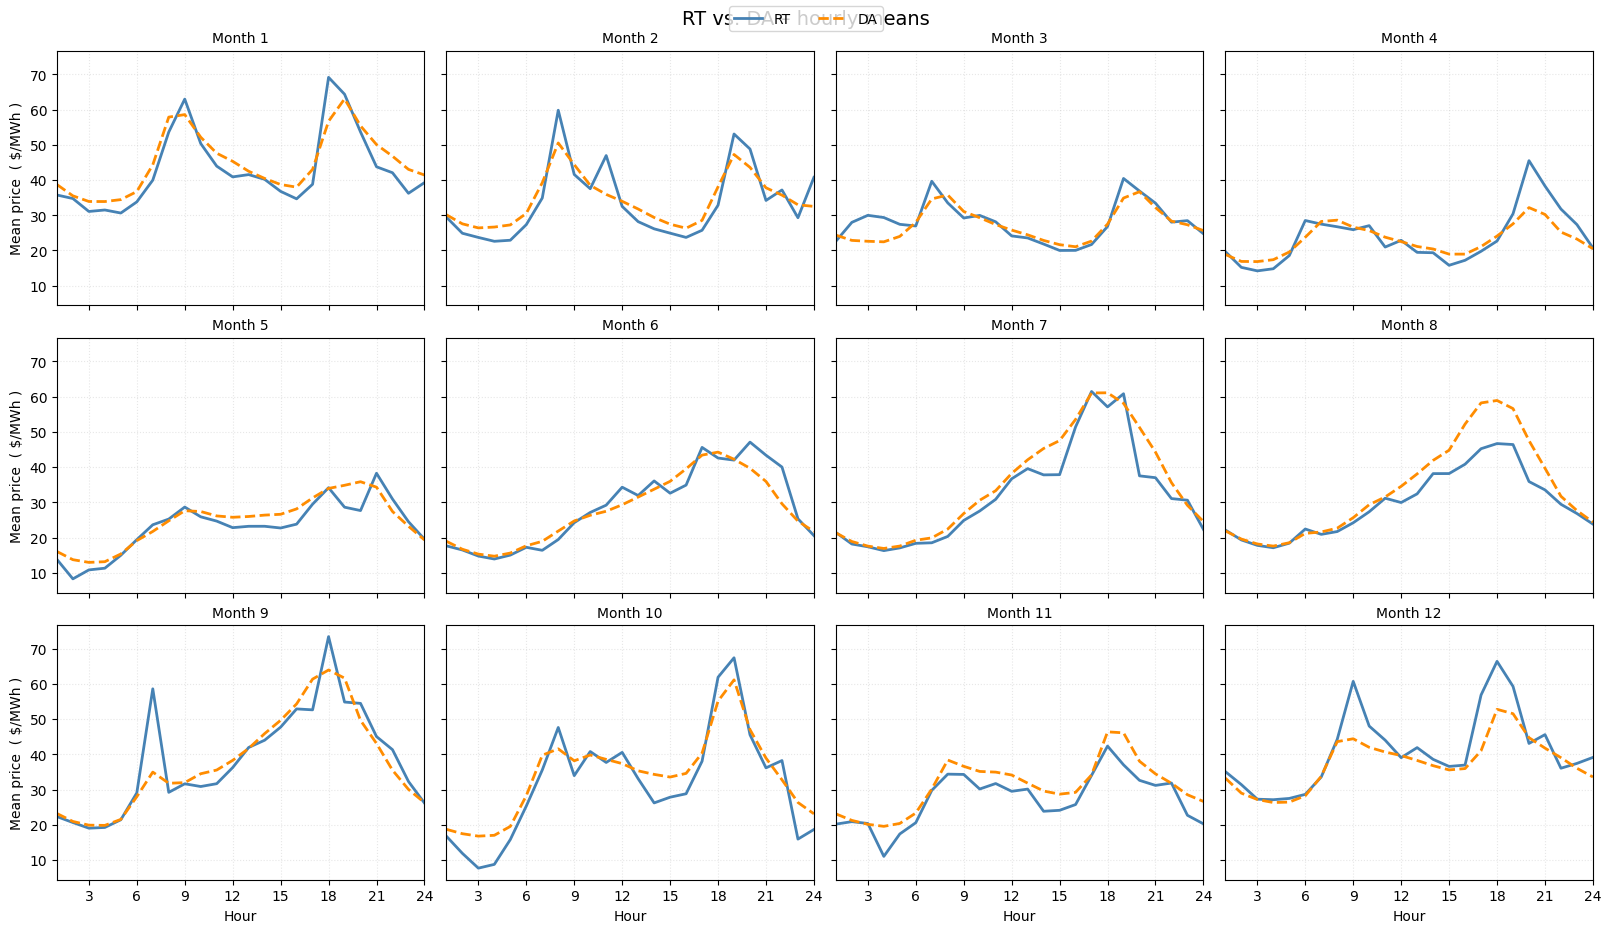

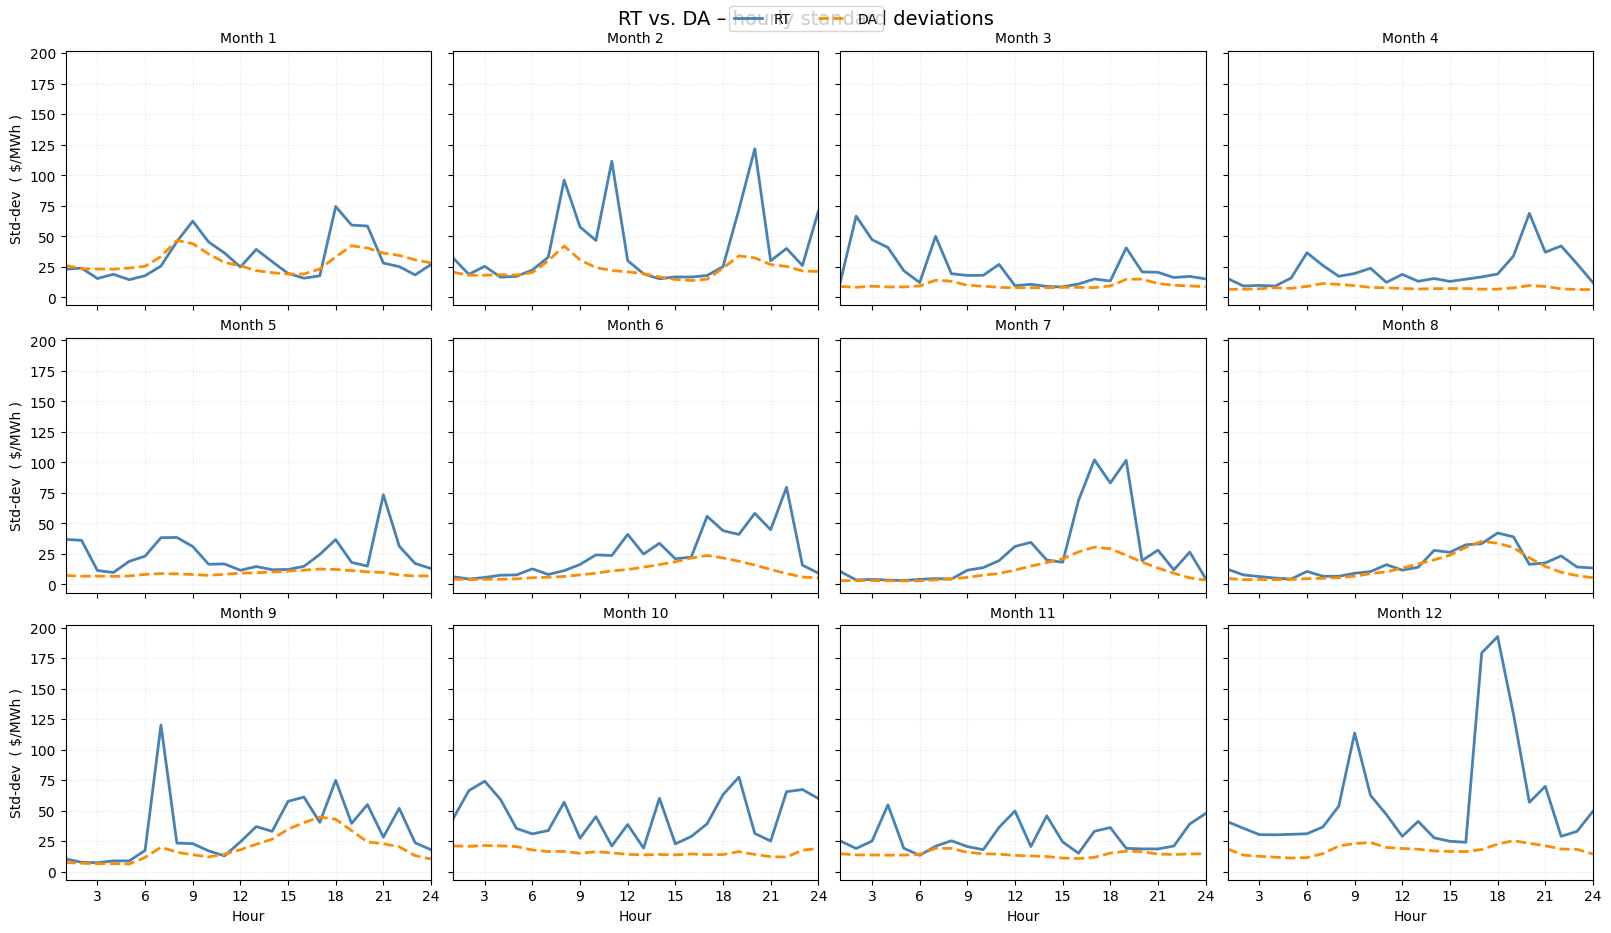

In [8]:

from matplotlib.ticker import MaxNLocator

def plot_monthly(rt_df, da_df, col, ylabel, title):
    """
    col      – 'mu' or 'sigma'
    ylabel   – axis label string
    title    – figure title
    """
    fig, axes = plt.subplots(
        3, 4, figsize=(16, 9), sharex=True, sharey=True,
        constrained_layout=True
    )
    axes = axes.ravel()

    for m in range(1, 13):
        ax = axes[m - 1]

        rt_m = rt_df[rt_df["MONTH"] == m].sort_values("HOUR")
        da_m = da_df[da_df["MONTH"] == m].sort_values("HOUR")

        ax.plot(rt_m["HOUR"], rt_m[col],
                lw=2, color="steelblue", label="RT")
        ax.plot(da_m["HOUR"], da_m[col],
                lw=2, ls="--", color="darkorange", label="DA")

        # cosmetics ------------
        ax.set_title(f"Month {m}", fontsize=10)
        ax.set_xlim(1, 24)
        ax.set_xticks(range(1, 25, 3))            # every 3 hours
        ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
        ax.grid(ls=":", alpha=0.3)

        if m in (9, 10, 11, 12):                  # bottom row
            ax.set_xlabel("Hour")
        if m in (1, 5, 9):                        # left column
            ax.set_ylabel(ylabel)

    # single legend outside the grid
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, loc="upper center")
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.show()

# -------------------------------------------------------------
# 3.  Call once for μ and once for σ
# -------------------------------------------------------------
plot_monthly(rt_stats, da_stats,
             col="mu",
             ylabel="Mean price  ( $/MWh )",
             title="RT vs. DA – hourly means")

plot_monthly(rt_stats, da_stats,
             col="sigma",
             ylabel="Std-dev  ( $/MWh )",
             title="RT vs. DA – hourly standard deviations")


### Fit logistic distribution (because it is like normal distribution but allowing fatter tail)

reshaping the dataset for fitting a distribution to historical prices

In [9]:
hour_cols = [f'HE{i}' for i in range(1, 25)]


DA_long  = (
    node_DA_LMP
    .melt(id_vars=['date', 'Month'], value_vars=hour_cols,
          var_name='Hour', value_name='LMP')
    .assign(Hour=lambda d: d['Hour'].str.extract(r'HE(\d+)').astype(int))
    .dropna(subset=['LMP'])
)

RT_long = (
    node_RT_LMP
    .melt(id_vars=['date', 'Month'], value_vars=hour_cols,
          var_name='Hour', value_name='LMP')
    .assign(Hour=lambda d: d['Hour'].str.extract(r'HE(\d+)').astype(int))
    .dropna(subset=['LMP'])
)

In [10]:
display(RT_long)
DA_long

,date,Month,Hour,LMP
0,2022-10-01,10,1,17.69
1,2022-10-02,10,1,13.95
2,2022-10-03,10,1,-7.72
3,2022-10-04,10,1,32.22
4,2022-10-05,10,1,41.72
...,...,...,...,...
21907,2025-03-27,3,24,26.77
21908,2025-03-28,3,24,19.82
21909,2025-03-29,3,24,35.58
21910,2025-03-30,3,24,18.06


,date,Month,Hour,LMP
0,2022-10-01,10,1,26.23
1,2022-10-02,10,1,23.31
2,2022-10-03,10,1,7.02
3,2022-10-04,10,1,15.53
4,2022-10-05,10,1,36.77
...,...,...,...,...
21907,2025-03-27,3,24,25.61
21908,2025-03-28,3,24,26.70
21909,2025-03-29,3,24,24.39
21910,2025-03-30,3,24,26.83


### Fit logistic regression to DA and RT prices

In [41]:
from scipy.stats import logistic

def fit_logistic(data):
    # 1) force numeric, turn bad tokens into NaN
    y = pd.to_numeric(data['LMP'], errors='coerce').values.astype(float)
    # 2) keep only finite values
    y = y[np.isfinite(y)]

    if len(y) < 2:                       # cannot fit with <2 obs.
        return pd.Series({
            'count'     : len(y),
            'loc'       : np.nan,
            'scale'     : np.nan,
            'mean_level': np.nan,
            'std_level' : np.nan,
        })

    loc, scale = logistic.fit(y)         # MLE
    scale = np.abs(scale)                # ensure scale is positive        
        
    mean_lvl   = loc
    std_lvl    = np.pi * scale / np.sqrt(3)

    return pd.Series({
        'count'     : len(y),
        'loc'       : loc,
        'scale'     : scale,
        'mean_level': mean_lvl,
        'std_level' : std_lvl,
    })

# ── Apply to DA and RT data ──────────────────────────────────────────
logistic_params_DA = (
    DA_long.groupby(['Month', 'Hour'])
           .apply(fit_logistic)
           .reset_index()
)

logistic_params_RT = (
    RT_long.groupby(['Month', 'Hour'])
           .apply(fit_logistic)
           .reset_index()
)

print(logistic_params_DA.head())
print(logistic_params_RT.head())


C:\Users\benja\AppData\Local\Temp\ipykernel_41356\2222740939.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_logistic)


   Month  Hour  count        loc      scale  mean_level  std_level
0      1     1   93.0  34.041596  10.570095   34.041596  19.172032
1      1     2   93.0  31.454070   9.410284   31.454070  17.068367
2      1     3   93.0  30.092826   8.902294   30.092826  16.146975
3      1     4   93.0  30.102168   8.910084   30.102168  16.161105
4      1     5   93.0  30.526617   8.950619   30.526617  16.234626
   Month  Hour  count        loc     scale  mean_level  std_level
0      1     1   93.0  31.949410  9.733351   31.949410  17.654345
1      1     2   93.0  30.982648  9.882696   30.982648  17.925228
2      1     3   93.0  29.074990  7.487944   29.074990  13.581628
3      1     4   93.0  28.720657  8.344229   28.720657  15.134756
4      1     5   93.0  29.006259  7.405165   29.006259  13.431483


C:\Users\benja\AppData\Local\Temp\ipykernel_41356\2222740939.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_logistic)


In [43]:
print(set(logistic_params_DA['count']))
print(set(logistic_params_RT['count']))

{85.0, 90.0, 60.0, 93.0, 62.0}
{90.0, 51.0, 93.0, 85.0, 52.0, 54.0, 55.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0}


In [44]:
# build hourly index for Jul 1 2025 → Jun 30 2026
rng = pd.date_range('2025-07-01', '2026-06-30 23:00', freq='h')
sim_df = pd.DataFrame({'DT': rng})
sim_df['Month'] = sim_df.DT.dt.month
sim_df['Hour']  = sim_df.DT.dt.hour + 1         # HE1–HE24

# attach monthly‐hourly DA stats
sim_df_DA = sim_df.merge(logistic_params_DA[['mean_level','scale','std_level','Month','Hour']], on=['Month','Hour'], how='left')
sim_df_RT = sim_df.merge(logistic_params_RT[['mean_level','scale','std_level','Month','Hour']], on=['Month','Hour'], how='left')

In [45]:
sim_df_DA
sim_df_RT

,DT,Month,Hour,mean_level,scale,std_level
0,2025-07-01 00:00:00,7,1,20.221164,3.081526,5.589270
1,2025-07-01 01:00:00,7,2,18.496932,1.970788,3.574613
2,2025-07-01 02:00:00,7,3,17.465735,1.952241,3.540974
3,2025-07-01 03:00:00,7,4,16.649996,1.732977,3.143273
4,2025-07-01 04:00:00,7,5,17.103934,1.774391,3.218390
...,...,...,...,...,...,...
8755,2026-06-30 19:00:00,6,20,35.042342,20.627606,37.414339
8756,2026-06-30 20:00:00,6,21,33.387631,16.767639,30.413134
8757,2026-06-30 21:00:00,6,22,28.629813,15.254027,27.667744
8758,2026-06-30 22:00:00,6,23,22.926540,5.261135,9.542643


## Check profits buying only in the DA market

In [46]:
# assumptions
n_miners    = 1000
power_mw    = n_miners * 3.25/1000          # 3.25 kW each → 3.25 MW total
btc_per_day = n_miners * 0.00008            # BTC/day total
btc_price0  = 93_000                        # starting BTC/USD
sigma_daily = 0.001                         # 0.1% per day
sigma_hour  = sigma_daily / np.sqrt(24)     # convert to hourly vol

hours   = len(sim_df_DA)
n_sims  = 1_000
profits = np.empty(n_sims)

hourly_paths = []

for i in range(n_sims):
    # 1) simulate BTC/USD path over each hour (GBM w/ zero drift)
    eps        = np.random.normal(0, sigma_hour, size=hours)
    price_fac  = np.exp(eps)                      # multiplicative factors
    btc_path   = btc_price0 * price_fac.cumprod() # size: (hours,)

    # 2) sample DA LMP each hour
    P_da       = np.random.logistic(sim_df_DA.mean_level, sim_df_DA.scale)

    # 3) compute revenue & cost per hour
    rev_hourly = btc_per_day * btc_path / 24      # $ revenue each hour
    cost_hourly= P_da * power_mw

    # 4) annual profit for this sim
    profits[i] = (rev_hourly - cost_hourly).sum()

    hourly_paths.append((rev_hourly - cost_hourly))

# summary
print("Mean profit:  ", profits.mean())

print("Profit σ:     ", profits.std())


Mean profit:   1836411.106747348
Profit σ:      31529.741835593934


In [47]:
# Convert hourly_paths to a DataFrame for easier manipulation
hourly_profits_df = pd.DataFrame(hourly_paths).T

# Add a datetime index to match the hourly data
hourly_profits_df.index = rng

# Resample to weekly frequency and sum the profits
weekly_profits = hourly_profits_df.resample('W').sum()

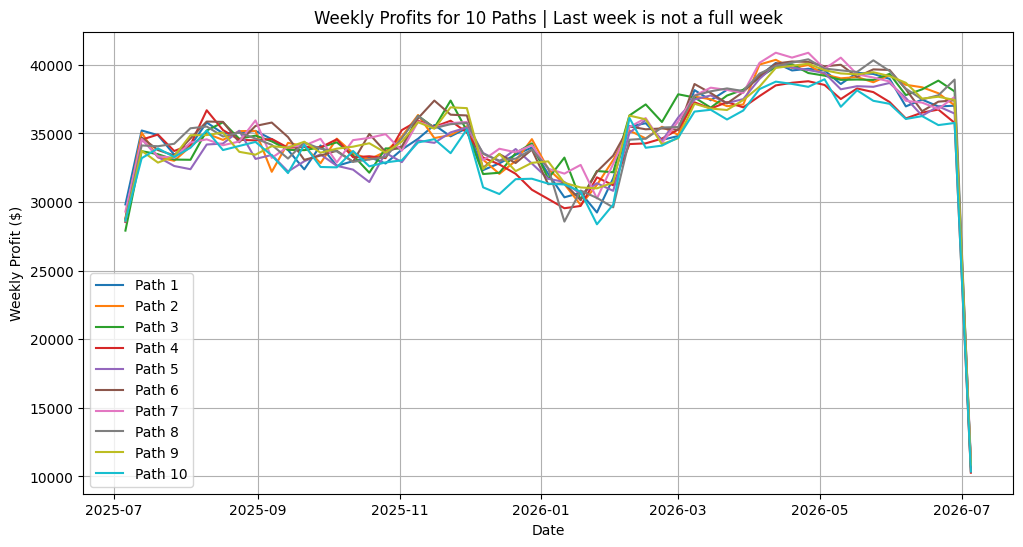

In [48]:
import matplotlib.pyplot as plt

# Select 10 paths to plot
sample_paths = weekly_profits.iloc[:, :10]

# Plot the weekly profits for the selected paths
plt.figure(figsize=(12, 6))
for i in range(sample_paths.shape[1]):
    plt.plot(sample_paths.index, sample_paths.iloc[:, i], label=f'Path {i+1}')

plt.title('Weekly Profits for 10 Paths | Last week is not a full week')
plt.xlabel('Date')
plt.ylabel('Weekly Profit ($)')
plt.legend()
plt.grid()
plt.show()

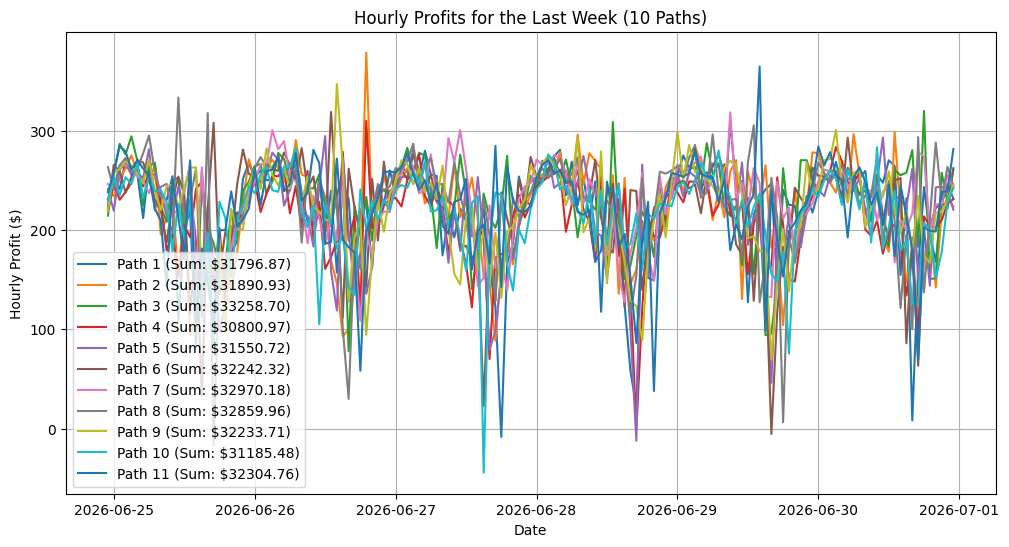

In [49]:
# Select the last week of hourly profits for the first 10 paths
last_week_start = rng[-1] - pd.Timedelta(days=6)
last_week_end = rng[-1]
last_week_data = hourly_profits_df.loc[last_week_start:last_week_end, :10]

# Calculate the sum of profits for each path for the last week
path_sums = last_week_data.sum()

# Plot the hourly profits for the last week
plt.figure(figsize=(12, 6))
for i in range(last_week_data.shape[1]):
    plt.plot(last_week_data.index, last_week_data.iloc[:, i], label=f'Path {i+1} (Sum: ${path_sums[i]:.2f})')

plt.title('Hourly Profits for the Last Week (10 Paths)')
plt.xlabel('Date')
plt.ylabel('Hourly Profit ($)')
plt.legend()
plt.grid()
plt.show()

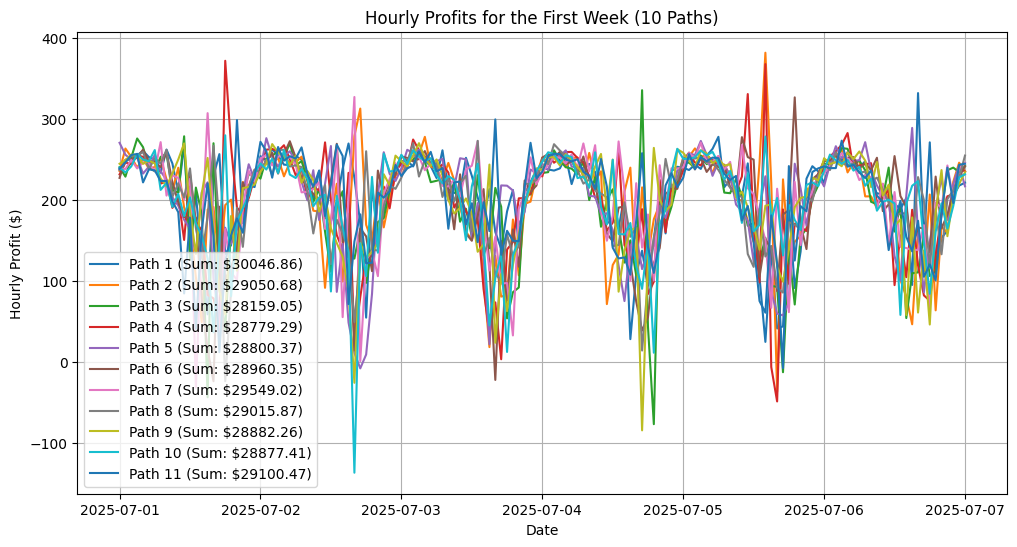

In [50]:
# Select the first week of hourly profits for the first 10 paths
first_week_start = rng[0]
first_week_end = rng[0] + pd.Timedelta(days=6)
first_week_data = hourly_profits_df.loc[first_week_start:first_week_end, :10]

# Calculate the sum of profits for each path for the first week
path_sums_first_week = first_week_data.sum()

# Plot the hourly profits for the first week
plt.figure(figsize=(12, 6))
for i in range(first_week_data.shape[1]):
    plt.plot(first_week_data.index, first_week_data.iloc[:, i], label=f'Path {i+1} (Sum: ${path_sums_first_week[i]:.2f})')

plt.title('Hourly Profits for the First Week (10 Paths)')
plt.xlabel('Date')
plt.ylabel('Hourly Profit ($)')
plt.legend()
plt.grid()
plt.show()

## Profits buying only in the RT

In [51]:
sim_df_RT

,DT,Month,Hour,mean_level,scale,std_level
0,2025-07-01 00:00:00,7,1,20.221164,3.081526,5.589270
1,2025-07-01 01:00:00,7,2,18.496932,1.970788,3.574613
2,2025-07-01 02:00:00,7,3,17.465735,1.952241,3.540974
3,2025-07-01 03:00:00,7,4,16.649996,1.732977,3.143273
4,2025-07-01 04:00:00,7,5,17.103934,1.774391,3.218390
...,...,...,...,...,...,...
8755,2026-06-30 19:00:00,6,20,35.042342,20.627606,37.414339
8756,2026-06-30 20:00:00,6,21,33.387631,16.767639,30.413134
8757,2026-06-30 21:00:00,6,22,28.629813,15.254027,27.667744
8758,2026-06-30 22:00:00,6,23,22.926540,5.261135,9.542643


In [52]:
# assumptions
n_miners    = 1000
power_mw    = n_miners * 3.25/1000          # 3.25 kW each → 3.25 MW total
btc_per_day = n_miners * 0.00008            # BTC/day total
btc_price0  = 93_000                        # starting BTC/USD
sigma_daily = 0.001                         # 0.1% per day
sigma_hour  = sigma_daily / np.sqrt(24)     # convert to hourly vol

hours   = len(sim_df_RT)
n_sims  = 1_000
profits_RT = np.empty(n_sims)

hourly_paths = []

for i in range(n_sims):
    # 1) simulate BTC/USD path over each hour (GBM w/ zero drift)
    eps        = np.random.normal(0, sigma_hour, size=hours)
    price_fac  = np.exp(eps)                      # multiplicative factors
    btc_path   = btc_price0 * price_fac.cumprod() # size: (hours,)

    # 2) sample RT LMP each hour
    P_rt       = np.random.logistic(sim_df_RT.mean_level, sim_df_RT.std_level)

    # 3) compute revenue & cost per hour
    rev_hourly = btc_per_day * btc_path / 24      # $ revenue each hour
    cost_hourly= P_rt * power_mw

    # 4) annual profit for this sim
    profits_RT[i] = (rev_hourly - cost_hourly).sum()

    hourly_paths.append((rev_hourly - cost_hourly))

# summary
print("Mean profit:  ", profits_RT.mean())

print("Profit σ:     ", profits_RT.std())

Mean profit:   1916837.629207384
Profit σ:      32361.47499420503
